In [250]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import pearsonr, spearmanr
import h3pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
from warnings import filterwarnings
import matplotlib.colors as colors
import geopandas as gpd 
import sys
import os
import seaborn as sns
import skunk
filterwarnings('ignore')
tqdm.pandas()

plt.rcParams.update({'font.family':'arial'})


In [251]:
with open('../trophic_niches.txt','r') as f:
    niche_list = f.read().strip().split('\n')
    

In [252]:
beta_geographic_summary = pd.read_csv('../../data/D07.BYM2_summary/beta_geographic_summary.csv')
beta_summary = pd.read_csv('../../data/D07.BYM2_summary/beta_summary.csv')


In [253]:
from plotting_utils import get_color_dict
color_dict = get_color_dict()
beta_summary


,niche,env_var,season,mu_beta_mean,mu_beta_std,mu_beta_q025,mu_beta_q975,mu_alpha_mean,mu_alpha_std,mu_alpha_q025,mu_alpha_q975,beta_lat_mean,beta_lat_std,beta_lat_q025,beta_lat_q975
0,all,mean_NDVI,spring,0.567871,0.011537,0.545078,0.590359,0.740144,0.137448,0.470686,1.011548,-0.001549,0.000686,-0.002889,-0.000198
1,all,delta_NDVI,spring,0.598235,0.011021,0.576515,0.619711,0.718009,0.134768,0.453491,0.976946,-0.002959,0.000653,-0.004231,-0.001683
2,all,tmax,spring,0.886800,0.011999,0.863588,0.910901,1.551772,0.127509,1.305060,1.802108,-0.004583,0.000652,-0.005903,-0.003306
3,all,tmean,spring,0.877291,0.011892,0.853820,0.900523,1.455770,0.124583,1.210183,1.699274,-0.004251,0.000660,-0.005522,-0.002917
4,all,tmin,spring,0.884582,0.011048,0.862759,0.906149,1.314695,0.123526,1.077252,1.559284,-0.003759,0.000580,-0.004875,-0.002632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Trophic_Level_Scavenger,mean_NDVI,spring,0.567259,0.014078,0.539473,0.594821,-0.693766,0.178302,-1.047160,-0.347593,0.000895,0.000831,-0.000729,0.002548
71,Trophic_Level_Scavenger,delta_NDVI,spring,0.609113,0.013700,0.582175,0.636185,-0.367298,0.175871,-0.716606,-0.031144,-0.000588,0.000802,-0.002180,0.000991
72,Trophic_Level_Scavenger,tmax,spring,0.797999,0.016261,0.765487,0.828860,0.119486,0.172985,-0.213932,0.457960,-0.002621,0.000865,-0.004316,-0.000962
73,Trophic_Level_Scavenger,tmean,spring,0.791683,0.016226,0.759867,0.823001,0.180818,0.174543,-0.160966,0.516246,-0.002095,0.000864,-0.003759,-0.000388


In [254]:
regression_data = beta_summary[
    (beta_summary['niche'].isin([i for i in color_dict.keys()])) & \
    (beta_summary['env_var'].isin(['delta_NDVI', 'tmin']))    
][['niche','env_var','mu_beta_mean']].pivot_table(index='niche', columns='env_var').droplevel(axis=1,level=0)

from scipy.stats import pearsonr
pearsonr(regression_data['delta_NDVI'], regression_data['tmin'])


PearsonRResult(statistic=0.9212311447050956, pvalue=5.6402031050723766e-05)

In [255]:
boxplot_data = beta_summary[
    (beta_summary['niche'].isin([i for i in color_dict.keys()]))
][['niche','env_var','mu_beta_mean']].pivot_table(index='niche', columns='env_var').droplevel(axis=1,level=0)


In [256]:
beta_geographic_summary_year_effect = pd.read_csv('../../data/D07.BYM2_summary/beta_geographic_summary_year_effect.csv')
beta_summary_year_effect = pd.read_csv('../../data/D07.BYM2_summary/beta_summary_year_effect.csv')


In [257]:
def plot_b(ax):
    for niche in color_dict.keys():
        sub_data = beta_summary[beta_summary['niche']==niche]
        ax.scatter(
            sub_data[sub_data['env_var']=='tmin']['mu_beta_mean'],
            sub_data[sub_data['env_var']=='delta_NDVI']['mu_beta_mean'],
            color = color_dict[niche],
            label=niche,
            s=70
        )
        
        x0 = sub_data[sub_data['env_var']=='tmin']['mu_beta_q025']
        x1 = sub_data[sub_data['env_var']=='tmin']['mu_beta_q975']
        x_ = sub_data[sub_data['env_var']=='tmin']['mu_beta_mean']
        y0 = sub_data[sub_data['env_var']=='delta_NDVI']['mu_beta_q025']
        y1 = sub_data[sub_data['env_var']=='delta_NDVI']['mu_beta_q975']
        y_ = sub_data[sub_data['env_var']=='delta_NDVI']['mu_beta_mean']
        
        ax.plot(
            [x0, x1], [y_, y_], color = color_dict[niche],
            linewidth=3,alpha=0.7
        )
        
        ax.plot(
            [x_, x_], [y0, y1], color = color_dict[niche],
            linewidth=3,alpha=0.7
        )
        
        
    x0 = beta_summary[beta_summary['env_var']=='tmin']['mu_beta_q025'].min()
    x1 = beta_summary[beta_summary['env_var']=='tmin']['mu_beta_q975'].max()

    y0 = beta_summary[beta_summary['env_var']=='delta_NDVI']['mu_beta_q025'].min()
    y1 = beta_summary[beta_summary['env_var']=='delta_NDVI']['mu_beta_q975'].max()


    # ax.plot([max(x0,y0), min(x1,y1)], [max(x0,y0), min(x1,y1)]) 
    ax.set_xlabel('Sensitivity to temperature\n(days per day)',fontsize=15)
    ax.set_ylabel('Sensitivity to green-up\n(days per day)',fontsize=15)
    ax.set_xticklabels(['{:.2f}'.format(i) for i in ax.get_xticks()], fontsize=13)
    ax.set_yticklabels(['{:.2f}'.format(i) for i in ax.get_yticks()], fontsize=13)
    # ax.set_ylabel('Sensitivity to green-up (days per day)',fontsize=15)
    ax.legend(bbox_to_anchor=(1,1), fontsize = 13)

        

In [258]:


def plot_b_plus_annotation(ax):
    plot_b(ax)
    ax.get_legend().remove()
    plt.tight_layout()


    def add_svg_annotation_coordinates(ax, name, loc):
        import skunk
        from matplotlib.offsetbox import AnnotationBbox
        
        if name == 'Trophic_Niche_Vertivore' or name == 'Trophic_Niche_Frugivore':
            size = (40,40)
        else:
            size=(30,30)

        # sknunk box with id sk2
        box = skunk.Box(size[0], size[1], name)
        ab = AnnotationBbox(box, loc,
                            xycoords='data',
                            boxcoords='data',
                            frameon=False)

        ax.add_artist(ab)
        

    def skunk_transform(name_list):
        
        a = {i:f"../../silhouette/SVG/{i}.svg" for i in name_list if not i=='all'}
        b = {'new_invertivore':f"../../silhouette/SVG/Trophic_Niche_Invertivore.svg"}
        svg = skunk.insert({**a, **b})
        return svg
        

    annotation_dict = {
        'all':{'name':'all','image_offset':(0.05,-0.07),'text_offset':(-0.005, +0.005)}, 
        'Trophic_Niche_Aquatic_predator':{'name':'Trophic_Niche_Aquatic_predator','image_offset':(-0.02,0.07),'text_offset':(0, 0.03)}, 
        'Trophic_Niche_Frugivore':{'name':'Trophic_Niche_Frugivore','image_offset':(0.02,-0.07),'text_offset':(0, -0.03)}, 
        'Trophic_Niche_Granivore':{'name':'Trophic_Niche_Granivore','image_offset':(-0.02,0.06),'text_offset':(0, 0.03)},
        'Trophic_Niche_Herbivore_aquatic':{'name':'Trophic_Niche_Herbivore_aquatic','image_offset':(0.02,-0.06),'text_offset':(0, -0.03)},
        'Trophic_Niche_Herbivore_terrestrial':{'name':'Trophic_Niche_Herbivore_terrestrial','image_offset':(0.05,-0.07),'text_offset':(0, -0.03)},
        'Trophic_Niche_Invertivore':{'name':'Trophic_Niche_Invertivore','image_offset':(-0.03,0.07),'text_offset':(0, 0.03)},
        'Trophic_Niche_Nectarivore':{'name':'Trophic_Niche_Nectarivore','image_offset':(-0.02,0.06),'text_offset':(0, 0.03)},
        'Trophic_Niche_Omnivore':{'name':'Trophic_Niche_Omnivore','image_offset':(0.05,-0.07),'text_offset':(0, -0.03)},
        'Trophic_Niche_Scavenger':{'name':'Trophic_Niche_Scavenger','image_offset':(-0.03,0.07),'text_offset':(0, 0.03)},
        'Trophic_Niche_Vertivore':{'name':'Trophic_Niche_Vertivore','image_offset':(0.05,-0.07),'text_offset':(0, -0.03)}
    }


    for niche in color_dict.keys():
        sub_data = beta_summary[beta_summary['niche']==niche]
        x_ = sub_data[sub_data['env_var']=='tmin']['mu_beta_mean']
        y_ = sub_data[sub_data['env_var']=='delta_NDVI']['mu_beta_mean']
        annotation_dict[niche]['loc'] = (float(x_), float(y_))
        
        if 'image_offset' not in annotation_dict[niche].keys():
            annotation_dict[niche]['image_offset'] = (0.9,0.55)
        

    for niche in color_dict.keys():
        # sub_data = beta_summary[beta_summary['niche']==niche]
        
        loc = annotation_dict[niche]['loc']
        image_offset = annotation_dict[niche]['image_offset']
        image_loc = (loc[0] + image_offset[0], 
                    loc[1] + image_offset[1])
        
        if not niche=='all':
            add_svg_annotation_coordinates(ax, niche, image_loc)

        if not 'text_offset' in annotation_dict[niche]:
            continue
        
        text_offset = annotation_dict[niche]['text_offset']
        test_loc = (
            loc[0] + image_offset[0] + text_offset[0], 
            loc[1] + image_offset[1]+ text_offset[1]
            )
        ax.annotate(niche.split('Trophic_Niche_')[-1].replace('_','\n'),
                    xy=test_loc,  # Position to place the annotation text
                    fontsize=13,
                    ha='center',va='center'
                    )
        
        if image_offset[1] > 0:
            ax.plot([loc[0], image_loc[0]+0.01], [loc[1], image_loc[1]-0.015], color='black',linewidth=0.7)
        elif image_offset[1] < 0:
            ax.plot([loc[0], image_loc[0]-0.01], [loc[1], image_loc[1]+0.015], color='black',linewidth=0.7)

    ax.annotate('Pearson\'s $\it{r}$ = 0.921\n$\it{P}$ < 0.001', xy=(0.69, 0.68), fontsize=13, ha='center',va='center')
    svg = skunk_transform(list(color_dict.keys()))
    return svg
            
    
    

In [259]:
def plot_a(beta_summary, ax):

    new_beta_summary = beta_summary.copy()
    new_beta_summary = new_beta_summary[new_beta_summary['niche']!='all']
    new_beta_summary['env_var'] = [i.replace('_',' ') for i in new_beta_summary['env_var'].values]
    
    new_var_ = []


    colors = []
    for i in new_beta_summary['env_var'].values:
        if i == 'tmax':
            new_var_.append('Tmax')
        elif i == 'tmin':
            new_var_.append('Tmin')
        elif i == 'tmean':
            new_var_.append('Tmean')
        else:
            new_var_.append(i)

            
    new_beta_summary['env_var'] = new_var_

    sns.boxplot(
        data = new_beta_summary,
        x = 'env_var',
        y = 'mu_beta_mean',
        ax=ax,
        # hue='color',
        palette={"mean NDVI": "tab:green", "delta NDVI": "tab:green", 
                "Tmax": "tab:orange", "Tmin": "tab:orange", "Tmean": "tab:orange"}
    )

    sns.stripplot(x = "env_var",
                y = "mu_beta_mean",
                color = 'black',
                alpha = 0.3,
                data = new_beta_summary,
                ax=ax)

    # ax.set_xlabel('Environmental variables',fontsize=15)
    ax.set_xlabel('',fontsize=15)
    ax.set_ylabel('Phenological sensitivity\nlong-term averaged\n(days per day)',fontsize=15)
    ax.set_xticklabels([i.get_text().replace(' ','\n') for i in ax.get_xticklabels()], fontsize=13)
    ax.set_yticklabels(['{:.1f}'.format(i) for i in ax.get_yticks()], fontsize=13)



In [260]:
def plot_schematic_diagram(ax):
    # simulate
    b1 = 0.8
    b2 = 0.3
    x = np.linspace(-1,1,10)
    # y1 = x * b1 + np.random.normal(0,0.2,len(x))
    # y2 = x * b2 + np.random.normal(0,0.2,len(x))
    y1 = np.array([-0.94047088, -0.81983008, -0.40785604, -0.02698314, -0.10720442,
       -0.00347025,  0.62445369,  0.7835969 ,  0.62543936,  0.54880262])
    y2 = np.array([-0.06950538, -0.21230133, -0.14496365, -0.3855741 , -0.17152754,
        0.14535716,  0.15878438,  0.31592365,  0.28558702,  0.17485614])

    sns.regplot(x=x, y=y1, ci=None, color='tab:orange', scatter_kws={'s':60}, ax=ax, label='Temperature tracking')
    sns.regplot(x=x, y=y2, ci=None, color='tab:green', scatter_kws={'s':60},ax=ax, label='Green-up tracking')
    ax.set_xlabel('Cue advance/delay (days)',fontsize=15)
    ax.set_ylabel('Bird arrival advance/delay (days)',fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(fontsize=15)


In [261]:
def plot_long_term_trend(ax):
    var1 = 'delta_NDVI'
    var2 = 'tmin'
    acc = 0
    x_list = []

    label_delta_NDVI = False
    label_tmin = False
    
    for niche in color_dict.keys():
        tmp = beta_summary_year_effect[beta_summary_year_effect['niche']==niche]
        
        if not len(tmp[tmp['env_var']==var1]) ==0:
            mean1 = tmp[tmp['env_var']==var1]['beta_year_mean'].iloc[0]
            lower1 = tmp[tmp['env_var']==var1]['beta_year_q025'].iloc[0]
            upper1 = tmp[tmp['env_var']==var1]['beta_year_q975'].iloc[0]

            if not label_delta_NDVI:
                ax.scatter(acc, mean1, c='tab:green', label='delta NDVI')
                label_delta_NDVI = True
            else:
                ax.scatter(acc, mean1, c='tab:green')
            ax.plot([acc, acc], [lower1, upper1], c='tab:green')
        acc += 1
        
        if not len(tmp[tmp['env_var']==var2]) ==0:
            mean2 = tmp[tmp['env_var']==var2]['beta_year_mean'].iloc[0]
            lower2 = tmp[tmp['env_var']==var2]['beta_year_q025'].iloc[0]
            upper2 = tmp[tmp['env_var']==var2]['beta_year_q975'].iloc[0]
            
            if not label_tmin:
                ax.scatter(acc, mean2, c='tab:orange', label='Tmin')
                label_tmin = True
            else:
                ax.scatter(acc, mean2, c='tab:orange')
                
            ax.plot([acc, acc], [lower2, upper2], c='tab:orange')
        acc += 1
    
    
        x_list.append(acc - 0.5)
        acc += 4
    
    ax.set_xticks(x_list, [niche.split('Trophic_Niche_')[-1].replace('_',' ') for niche in list(color_dict.keys())],
            fontsize=13, rotation=45, ha='right', rotation_mode='anchor') 
    ax.set_ylabel('Long-term trend of sensitivity\n(days per day per year)', fontsize=15)
    ax.axhline(0, c='tab:grey', alpha=0.7, linestyle='dashed')
    ax.legend(fontsize=13)
        


In [262]:
# fig,ax = plt.subplots()
# simulate

def plot_schematic_diagram_long_term_trend(ax):

    x = np.array([int(i) for i in range(2010, 2021)])
    x_more = np.linspace(2010,2020, 100)
    x_norm = x - np.mean(x)
    x_more_nrom = x_more - np.mean(x)

    b1_mean = -0.015878008634662363
    b1_std = 0.00849652373431303
    b1_y = np.array([-0.00955325,0.16491453,0.05403584,0.02562388,0.04506432,-0.02627813, 0.08039878,-0.10918576,-0.1381204,-0.02126597,-0.04661663])
    a1_mean = 0.524203651094371
    a1_std = 0.029057195797935996

    b2_mean = -0.005103489873881524
    b2_std = 0.010027768978359311
    b2_y = np.array([0.02904713,0.02800679,0.02202009,-0.04236721,0.08784039,0.00164604,0.06474597,-0.08811581,-0.18151636,-0.00842048,0.09067649])
    a2_mean = 0.738165305453065
    a2_std = 0.032740960640864694


    sns.scatterplot(
        x=x, y=b1_y + a1_mean,color='tab:green',label='delta NDVI',s=60,ax=ax
    )

    sns.lineplot(x=x, y= a1_mean + b1_mean * x_norm,color='tab:green',linewidth=2,ax=ax)

    # get_CI
    yy_list = []
    for i in range(10000):
        from scipy.stats import norm
        b = norm.rvs(loc=b1_mean, scale=b1_std)
        a = norm.rvs(loc=a1_mean, scale=a1_std)
        yy = a + b * x_more_nrom
        yy_list.append(yy)
    yy_list = np.array(yy_list)
    upper_line = np.quantile(yy_list, 0.975, axis=0)
    lower_line = np.quantile(yy_list, 0.025, axis=0)
    ax.fill_between(x = x_more, y1=upper_line, y2=lower_line,color='tab:green',alpha=0.2,linewidth=0, interpolate=True)


    sns.scatterplot(
        x=x, y=b2_y + a2_mean,color='tab:orange',label='Tmin',s=60,ax=ax
    )
    sns.lineplot(x=x, y= a2_mean + b2_mean * x_norm,color='tab:orange',linewidth=2,ax=ax)

    # get_CI
    yy_list = []
    for i in range(10000):
        from scipy.stats import norm
        b = norm.rvs(loc=b2_mean, scale=b2_std)
        a = norm.rvs(loc=a2_mean, scale=a2_std)
        yy = a + b * x_more_nrom
        yy_list.append(yy)
    yy_list = np.array(yy_list)
    upper_line = np.quantile(yy_list, 0.975, axis=0)
    lower_line = np.quantile(yy_list, 0.025, axis=0)
    ax.fill_between(x = x_more, y1=upper_line, y2=lower_line,color='tab:orange',alpha=0.2,linewidth=0, interpolate=True)

    # sns.regplot(x=x, y=y1, ci=None, color='tab:orange', scatter_kws={'s':60}, ax=ax, label='Temperature tracking')
    # sns.regplot(x=x, y=y2, ci=None, color='tab:green', scatter_kws={'s':60},ax=ax, label='Green-up tracking')

    ax.set_xlabel('Year',fontsize=15)
    ax.set_ylabel('Phenological sensitivity\n(days per day)',fontsize=15)
    ax.set_xticks(x, x, fontsize=13, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=13)
    ax.legend(fontsize=15)


    import skunk
    from matplotlib.offsetbox import AnnotationBbox
    size=(35,35)

    box = skunk.Box(size[0], size[1], 'new_invertivore')
    ab = AnnotationBbox(box, (2012,0.42),
                        xycoords='data',
                        boxcoords='data',
                        frameon=False)
    ax.add_artist(ab)
    ax.annotate('Invertivore',
                xy=(2012,0.35),  # Position to place the annotation text
                fontsize=13,
                ha='center',va='center')



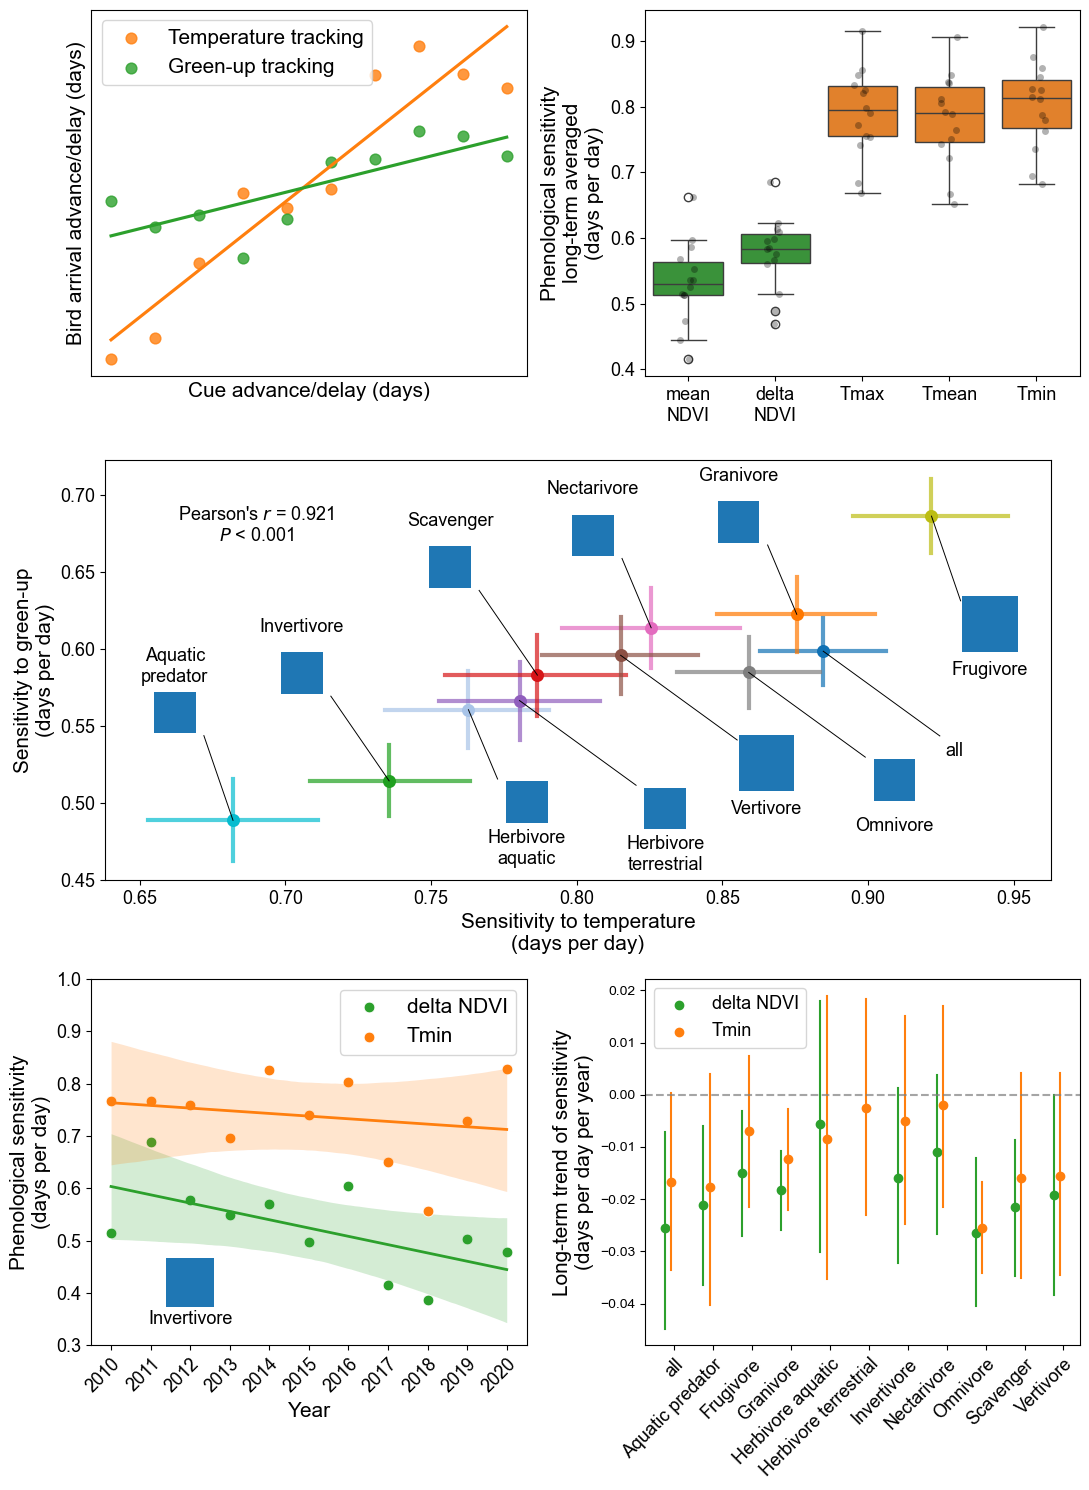

In [263]:
fig,axs = plt.subplots(3,2,figsize=(11,10*(3/2)), 
                      gridspec_kw={'height_ratios': [1, 1.3, 1]}
                      )
plot_schematic_diagram(axs[0,0])
plot_a(beta_summary, axs[0,1])
plt.tight_layout()

gs = axs[0,0].get_gridspec()
# remove the underlying Axes
for ax in [axs[1,0], axs[1,1]]:
    ax.remove()

axbig = fig.add_axes([0.1, 0.41, 0.86, 0.28])

plot_long_term_trend(axs[2,1])
plot_schematic_diagram_long_term_trend(axs[2,0])

svg = plot_b_plus_annotation(axbig)

plt.tight_layout()

import cairosvg
cairosvg.svg2pdf(bytestring=svg, write_to='Fig2.pdf')


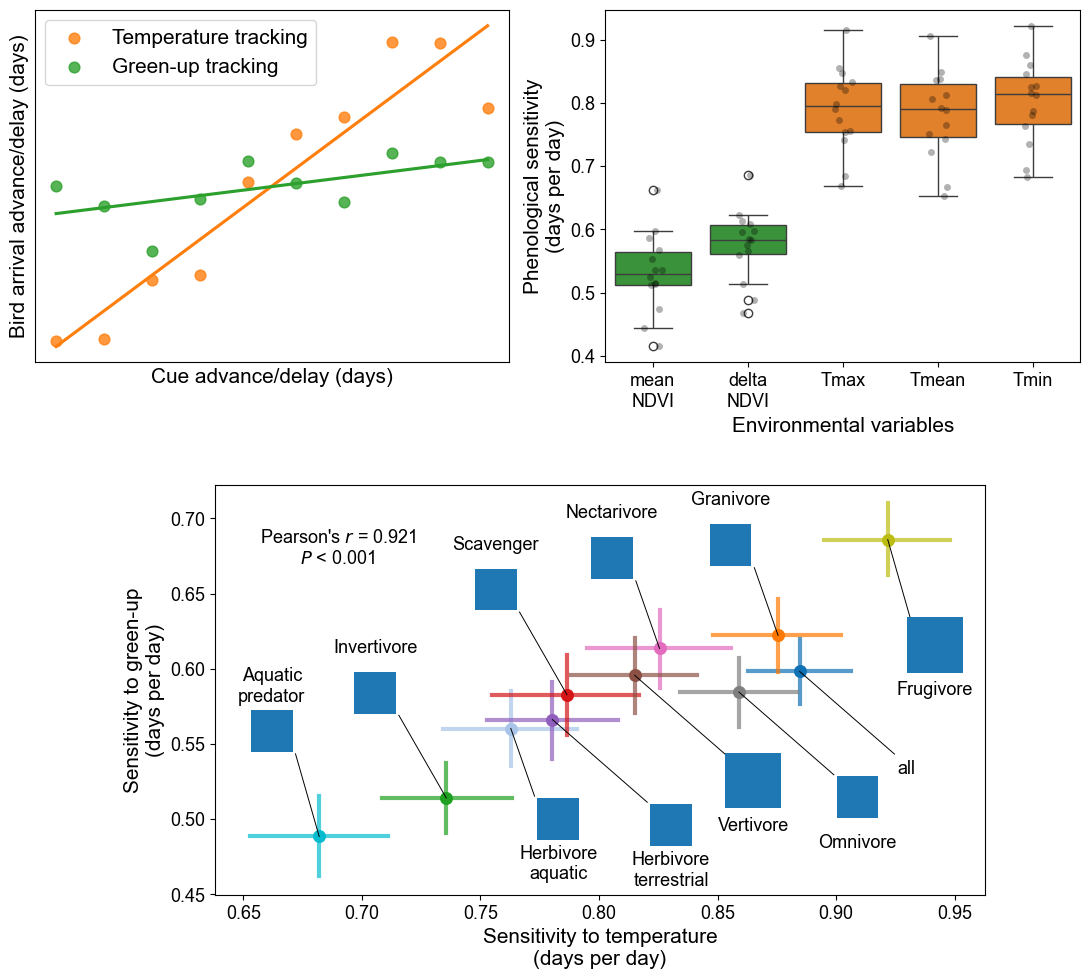

In [23]:
fig,axs = plt.subplots(2,2,figsize=(11,10), 
                      gridspec_kw={'height_ratios': [1, 1.5]}
                      )
plot_schematic_diagram(axs[0,0])
plot_a(beta_summary, axs[0,1])
plt.tight_layout()

gs = axs[0,0].get_gridspec()
# remove the underlying Axes
for ax in [axs[1,0], axs[1,1]]:
    ax.remove()
# axbig = fig.add_subplot(gs[1:,0:])
axbig = fig.add_axes([0.2, 0.1, 0.7, 0.41])

svg = plot_b_plus_annotation(axbig)

plt.tight_layout()

import cairosvg
cairosvg.svg2pdf(bytestring=svg, write_to='Fig2.pdf')



In [60]:
# pca_data = {
#     'niche':color_dict.keys(),
#     'sensitivity_to_tmin':[beta_summary[(beta_summary['niche']==i) & (beta_summary['env_var']=='tmin')]['mu_beta_mean'].iloc[0] for i in color_dict.keys()],
#     'sensitivity_to_delta_NDVI':[beta_summary[(beta_summary['niche']==i) & (beta_summary['env_var']=='delta_NDVI')]['mu_beta_mean'].iloc[0] for i in color_dict.keys()]
# }

# pca_data = pd.DataFrame(pca_data)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=2).fit(pca_data.iloc[:,1:])
# pcs = pca.transform(pca_data.iloc[:,1:])
# pca_data['PC1'] = pcs[:,0]
# pca_data['PC2'] = pcs[:,1]

# print(pca.explained_variance_ratio_)
# # print(pca_data.iloc[:,1:].corr().round(2))

# pca_data['Sensitivity_index'] = -pca_data['PC1']
# pca_data['Cue_use_index'] = pca_data['PC2']



[0.96400497 0.03599503]
